Import files and libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from statsmodels.graphics.tsaplots import plot_acf
import os
from colorama import Fore
from prophet import Prophet
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
np.random.seed(7)

Importing plotly failed. Interactive plots will not work.


1) Import and Preprocess Each Dataset: Load each dataset and clean the data as needed.

In [3]:
petrignano = pd.read_csv("data/raw/Aquifer_Petrignano.csv")
auser = pd.read_csv("data/raw/Aquifer_Auser.csv")
doganella = pd.read_csv("data/raw/Aquifer_Doganella.csv")
luco = pd.read_csv("data/raw/Aquifer_Luco.csv")
amiata = pd.read_csv("data/raw/Water_Spring_Amiata.csv")
madonna = pd.read_csv("data/raw/Water_Spring_Madonna_di_Canneto.csv")
lupa= pd.read_csv("data/raw/Water_Spring_Lupa.csv")
arno= pd.read_csv("data/raw/River_Arno.csv")
bilancino= pd.read_csv("data/raw/Lake_Bilancino.csv")

Petrignano is a problematic dataset, needs separate attention

In [4]:
import pandas as pd

# Define waterbody datasets
waterbodies = [petrignano, auser, doganella, luco, amiata, madonna, lupa, arno, bilancino]

targets = ['Depth_to_Groundwater_SAL', 'Depth_to_Groundwater_COS', 'Depth_to_Groundwater_LT2',
           'Depth_to_Groundwater_P24', 'Depth_to_Groundwater_P25', 'Depth_to_Groundwater_Pozzo_1', 
           'Depth_to_Groundwater_Pozzo_2', 'Depth_to_Groundwater_Pozzo_3', 'Depth_to_Groundwater_Pozzo_4', 
           'Depth_to_Groundwater_Pozzo_5', 'Depth_to_Groundwater_Pozzo_6', 'Depth_to_Groundwater_Pozzo_7',
           'Depth_to_Groundwater_Pozzo_8', 'Depth_to_Groundwater_Pozzo_9', 'Depth_to_Groundwater_Podere_Casetta',
           'Flow_Rate_Bugnano', 'Flow_Rate_Arbure', 'Flow_Rate_Emricciolo', 'Flow_Rate_Galleria_Alta',
           'Flow_Rate_Madonna_di_Canneto', 'Flow_Rate_Lupa', 'Hydrometry_Nave_di_Rosano', 'Lake_Level',
           'Flow_Rate']


def clean_waterbody(waterbody, targets):
   
    waterbody['Date'] = pd.to_datetime(waterbody['Date'], errors='coerce')
    
    if 'targets' in waterbody.columns:
        waterbody = waterbody[waterbody['targets'].notna()].reset_index(drop=True)
    
    features = [col for col in waterbody.columns if col not in targets]
    
    if 'delta' in waterbody.columns:
        waterbody = waterbody.drop('delta', axis=1)
    
    waterbody = waterbody.dropna()  # Drop rows with missing values
    
    return waterbody


cleaned_waterbodies = []
for waterbody in waterbodies:
    cleaned_waterbodies.append(clean_waterbody(waterbody, targets))


cleaned_petrignano = cleaned_waterbodies[0]
cleaned_petrignano.head() 
print("clean_waterbody")

/tmp/ipykernel_9417/2378191940.py:18: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  waterbody['Date'] = pd.to_datetime(waterbody['Date'], errors='coerce')


clean_waterbody


2) Create and Train Prophet Models: For each feature (target), create a Prophet model, using any other relevant features (e.g., rainfall, temperature, or other external regressors) as inputs.


In [5]:
from prophet import Prophet
import pandas as pd

# Cleaned_waterbodies is a list of cleaned datasets from the previous code
# Create a list of target features per waterbody
target_features_dict = {
    'Aquifer_Auser': ['Depth_to_Groundwater_SAL', 'Depth_to_Groundwater_COS', 'Depth_to_Groundwater_LT2'],
    'Aquifer_Petrignano': ['Depth_to_Groundwater_P24', 'Depth_to_Groundwater_P25'],
    'Aquifer_Doganella': ['Depth_to_Groundwater_Pozzo_1', 'Depth_to_Groundwater_Pozzo_2', 'Depth_to_Groundwater_Pozzo_3', 
                          'Depth_to_Groundwater_Pozzo_4', 'Depth_to_Groundwater_Pozzo_5', 'Depth_to_Groundwater_Pozzo_6', 
                          'Depth_to_Groundwater_Pozzo_7', 'Depth_to_Groundwater_Pozzo_8', 'Depth_to_Groundwater_Pozzo_9'],
    'Aquifer_Luco': ['Depth_to_Groundwater_Podere_Casetta'],
    'Water_Spring_Amiata': ['Flow_Rate_Bugnano', 'Flow_Rate_Arbure', 'Flow_Rate_Emricciolo', 'Flow_Rate_Galleria_Alta'],
    'Water_Spring_Madonna_di_Canneto': ['Flow_Rate_Madonna_di_Canneto'],
    'Water_Spring_Lupa': ['Flow_Rate_Lupa'],
    'River_Arno': ['Hydrometry_Nave_di_Rosano'],
    'Lake_Bilancino': ['Lake_Level', 'Flow_Rate']
}


3) Make Predictions: Use the trained Prophet models to predict the future values of the target features.

In [6]:
# Loop through cleaned waterbodies and fit Prophet models for available targets
prophet_models = {}
predictions = {}

for i, waterbody in enumerate(cleaned_waterbodies):
    # Get the name of the dataset (assuming the order corresponds to the original names)
    waterbody_name = list(target_features_dict.keys())[i]
    target_features = target_features_dict[waterbody_name]
    
    # Loop through each target feature for the current waterbody
    for target in target_features:
        if target in waterbody.columns:
            # Prepare the data for Prophet
            petrignano_prophet = waterbody[['Date', target]].rename(columns={'Date': 'ds', target: 'y'})

            # Initialize and fit the Prophet model
            model = Prophet()
            model.fit(petrignano_prophet)

            # Make future predictions (e.g., for the next 30 days)
            future = model.make_future_dataframe(periods=30)
            forecast = model.predict(future)

            # Store the fitted model and predictions
            prophet_models[f"{waterbody_name}_{target}"] = model
            predictions[f"{waterbody_name}_{target}"] = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

            print(f"Model fitted for {waterbody_name} on target {target}. Predictions available.")



00:50:03 - cmdstanpy - INFO - Chain [1] start processing


00:50:03 - cmdstanpy - INFO - Chain [1] done processing
00:50:03 - cmdstanpy - INFO - Chain [1] start processing
00:50:04 - cmdstanpy - INFO - Chain [1] done processing


Model fitted for Aquifer_Doganella on target Depth_to_Groundwater_Pozzo_1. Predictions available.
Model fitted for Aquifer_Doganella on target Depth_to_Groundwater_Pozzo_2. Predictions available.


00:50:04 - cmdstanpy - INFO - Chain [1] start processing
00:50:04 - cmdstanpy - INFO - Chain [1] done processing
00:50:04 - cmdstanpy - INFO - Chain [1] start processing
00:50:04 - cmdstanpy - INFO - Chain [1] done processing


Model fitted for Aquifer_Doganella on target Depth_to_Groundwater_Pozzo_3. Predictions available.
Model fitted for Aquifer_Doganella on target Depth_to_Groundwater_Pozzo_4. Predictions available.


00:50:04 - cmdstanpy - INFO - Chain [1] start processing
00:50:04 - cmdstanpy - INFO - Chain [1] done processing
00:50:04 - cmdstanpy - INFO - Chain [1] start processing


Model fitted for Aquifer_Doganella on target Depth_to_Groundwater_Pozzo_5. Predictions available.


00:50:05 - cmdstanpy - INFO - Chain [1] done processing
00:50:05 - cmdstanpy - INFO - Chain [1] start processing
00:50:05 - cmdstanpy - INFO - Chain [1] done processing


Model fitted for Aquifer_Doganella on target Depth_to_Groundwater_Pozzo_6. Predictions available.


00:50:05 - cmdstanpy - INFO - Chain [1] start processing
00:50:05 - cmdstanpy - INFO - Chain [1] done processing


Model fitted for Aquifer_Doganella on target Depth_to_Groundwater_Pozzo_7. Predictions available.


00:50:05 - cmdstanpy - INFO - Chain [1] start processing
00:50:05 - cmdstanpy - INFO - Chain [1] done processing


Model fitted for Aquifer_Doganella on target Depth_to_Groundwater_Pozzo_8. Predictions available.


00:50:05 - cmdstanpy - INFO - Chain [1] start processing
00:50:05 - cmdstanpy - INFO - Chain [1] done processing
00:50:05 - cmdstanpy - INFO - Chain [1] start processing
00:50:05 - cmdstanpy - INFO - Chain [1] done processing


Model fitted for Aquifer_Doganella on target Depth_to_Groundwater_Pozzo_9. Predictions available.
Model fitted for Aquifer_Luco on target Depth_to_Groundwater_Podere_Casetta. Predictions available.


00:50:06 - cmdstanpy - INFO - Chain [1] start processing
00:50:06 - cmdstanpy - INFO - Chain [1] done processing


Model fitted for Water_Spring_Amiata on target Flow_Rate_Bugnano. Predictions available.
Model fitted for Water_Spring_Amiata on target Flow_Rate_Arbure. Predictions available.


00:50:06 - cmdstanpy - INFO - Chain [1] start processing
00:50:06 - cmdstanpy - INFO - Chain [1] done processing
00:50:06 - cmdstanpy - INFO - Chain [1] start processing
00:50:06 - cmdstanpy - INFO - Chain [1] done processing


Model fitted for Water_Spring_Amiata on target Flow_Rate_Galleria_Alta. Predictions available.
Model fitted for Water_Spring_Madonna_di_Canneto on target Flow_Rate_Madonna_di_Canneto. Predictions available.


00:50:06 - cmdstanpy - INFO - Chain [1] start processing
00:50:06 - cmdstanpy - INFO - Chain [1] done processing
00:50:07 - cmdstanpy - INFO - Chain [1] start processing
00:50:07 - cmdstanpy - INFO - Chain [1] done processing


Model fitted for Water_Spring_Lupa on target Flow_Rate_Lupa. Predictions available.
Model fitted for River_Arno on target Hydrometry_Nave_di_Rosano. Predictions available.


00:50:07 - cmdstanpy - INFO - Chain [1] start processing
00:50:07 - cmdstanpy - INFO - Chain [1] done processing
00:50:08 - cmdstanpy - INFO - Chain [1] start processing


Model fitted for Lake_Bilancino on target Lake_Level. Predictions available.


00:50:08 - cmdstanpy - INFO - Chain [1] done processing


Model fitted for Lake_Bilancino on target Flow_Rate. Predictions available.


In [7]:
# Example: Access the predictions for a specific target
example_predictions = predictions.get('Aquifer_Doganella_Depth_to_Groundwater_Pozzo_1', None)
print(example_predictions)

            ds       yhat  yhat_lower  yhat_upper
0   2019-01-04 -42.544791  -49.832888  -34.914521
1   2019-01-06 -42.254655  -49.067189  -34.725782
2   2019-01-08 -41.631579  -49.399020  -34.118827
3   2019-01-09 -42.647670  -50.283432  -35.345012
4   2019-02-04 -41.550684  -48.700657  -34.166616
..         ...        ...         ...         ...
102 2020-12-31 -47.882703  -55.685189  -40.192312
103 2021-01-01 -48.570875  -56.261050  -41.266755
104 2021-01-02 -47.631801  -55.529291  -39.679565
105 2021-01-03 -48.280833  -55.483491  -40.285926
106 2021-01-04 -47.345974  -55.121644  -39.858822

[107 rows x 4 columns]


In [8]:
print("Available predictions keys:")
for key in predictions.keys():
    print(key)

if example_predictions is not None:
    print(example_predictions.head())
else:
    print("No predictions available for this {key} target.")

Available predictions keys:
Aquifer_Doganella_Depth_to_Groundwater_Pozzo_1
Aquifer_Doganella_Depth_to_Groundwater_Pozzo_2
Aquifer_Doganella_Depth_to_Groundwater_Pozzo_3
Aquifer_Doganella_Depth_to_Groundwater_Pozzo_4
Aquifer_Doganella_Depth_to_Groundwater_Pozzo_5
Aquifer_Doganella_Depth_to_Groundwater_Pozzo_6
Aquifer_Doganella_Depth_to_Groundwater_Pozzo_7
Aquifer_Doganella_Depth_to_Groundwater_Pozzo_8
Aquifer_Doganella_Depth_to_Groundwater_Pozzo_9
Aquifer_Luco_Depth_to_Groundwater_Podere_Casetta
Water_Spring_Amiata_Flow_Rate_Bugnano
Water_Spring_Amiata_Flow_Rate_Arbure
Water_Spring_Amiata_Flow_Rate_Galleria_Alta
Water_Spring_Madonna_di_Canneto_Flow_Rate_Madonna_di_Canneto
Water_Spring_Lupa_Flow_Rate_Lupa
River_Arno_Hydrometry_Nave_di_Rosano
Lake_Bilancino_Lake_Level
Lake_Bilancino_Flow_Rate
          ds       yhat  yhat_lower  yhat_upper
0 2019-01-04 -42.544791  -49.832888  -34.914521
1 2019-01-06 -42.254655  -49.067189  -34.725782
2 2019-01-08 -41.631579  -49.399020  -34.118827
3 2019-

In [9]:
print(predictions.keys())

dict_keys(['Aquifer_Doganella_Depth_to_Groundwater_Pozzo_1', 'Aquifer_Doganella_Depth_to_Groundwater_Pozzo_2', 'Aquifer_Doganella_Depth_to_Groundwater_Pozzo_3', 'Aquifer_Doganella_Depth_to_Groundwater_Pozzo_4', 'Aquifer_Doganella_Depth_to_Groundwater_Pozzo_5', 'Aquifer_Doganella_Depth_to_Groundwater_Pozzo_6', 'Aquifer_Doganella_Depth_to_Groundwater_Pozzo_7', 'Aquifer_Doganella_Depth_to_Groundwater_Pozzo_8', 'Aquifer_Doganella_Depth_to_Groundwater_Pozzo_9', 'Aquifer_Luco_Depth_to_Groundwater_Podere_Casetta', 'Water_Spring_Amiata_Flow_Rate_Bugnano', 'Water_Spring_Amiata_Flow_Rate_Arbure', 'Water_Spring_Amiata_Flow_Rate_Galleria_Alta', 'Water_Spring_Madonna_di_Canneto_Flow_Rate_Madonna_di_Canneto', 'Water_Spring_Lupa_Flow_Rate_Lupa', 'River_Arno_Hydrometry_Nave_di_Rosano', 'Lake_Bilancino_Lake_Level', 'Lake_Bilancino_Flow_Rate'])


In [11]:
import matplotlib.pyplot as plt

# Loop through the waterbody names and their corresponding target features
for waterbody_name, targets in target_features_dict.items():
    for target in targets:
        # Construct the key to access predictions
        prediction_key = f"{waterbody_name}_{target}"
        
        # Check if predictions exist for the current waterbody and target
        if prediction_key in predictions:
            # Get the cleaned data for the current waterbody
            index = cleaned_waterbodies.index(waterbody_name)
            cleaned_data = cleaned_waterbodies[index]
            
            # Extract actual observed data
            actual_data = cleaned_data[['Date', target]].copy()
            actual_data.columns = ['ds', 'y']  # Rename for Prophet format

            plt.figure(figsize=(12, 6))

            # Plot actual data
            plt.plot(actual_data['ds'], actual_data['y'], label='Observed', color='blue', marker='o', markersize=3)

            # Extract forecast data
            forecast_data = predictions[prediction_key]

            # Plot forecast
            plt.plot(forecast_data['ds'], forecast_data['yhat'], label='Forecast', color='orange', linestyle='--')

            # Plot uncertainty intervals
            plt.fill_between(forecast_data['ds'], 
                             forecast_data['yhat_lower'], 
                             forecast_data['yhat_upper'], 
                             color='gray', alpha=0.2, label='Uncertainty Interval')

            # Title and labels
            plt.title(f'Predictions for {waterbody_name} - {target}')
            plt.xlabel('Date')
            plt.ylabel(target)
            plt.legend()
            plt.xticks(rotation=45)
            plt.tight_layout()
            
            # Show the plot
            plt.show()
        else:
            print(f"No predictions available for {waterbody_name} - {target}.")


No predictions available for Aquifer_Auser - Depth_to_Groundwater_SAL.
No predictions available for Aquifer_Auser - Depth_to_Groundwater_COS.
No predictions available for Aquifer_Auser - Depth_to_Groundwater_LT2.
No predictions available for Aquifer_Petrignano - Depth_to_Groundwater_P24.
No predictions available for Aquifer_Petrignano - Depth_to_Groundwater_P25.


ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

ValueError: 'Aquifer' is not in list

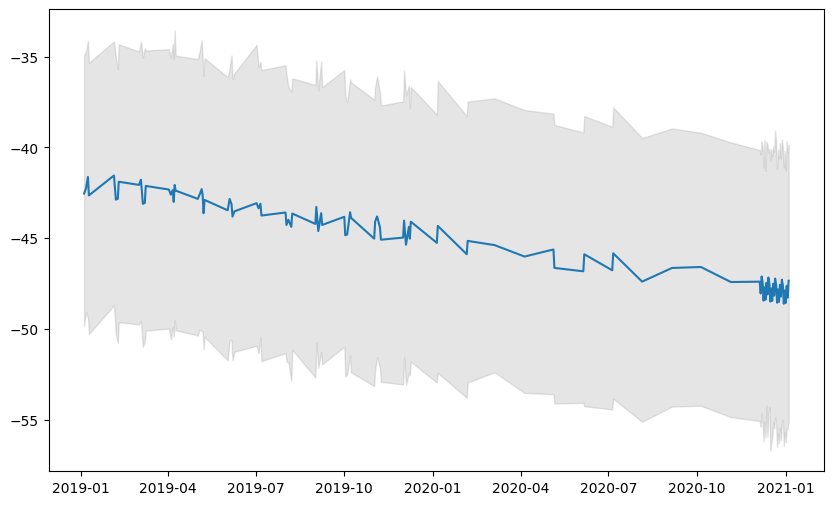

In [12]:
for target in predictions.keys():
    plt.figure(figsize=(10, 6))

    # Get predicted values
    forecast = predictions[target]

    # Plot forecasted yhat values
    plt.plot(forecast['ds'], forecast['yhat'], label="Predicted")

    # Plot confidence interval
    plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='gray', alpha=0.2, label='Uncertainty Interval')

    # Plot the actual data if it exists
    waterbody_index = list(target_features_dict.keys()).index(target.split('_')[0])
    actual_values = cleaned_waterbodies[waterbody_index][target.split('_')[1]]
    plt.plot(cleaned_waterbodies[waterbody_index]['Date'], actual_values, label="Actual", color='red')

    # Customize plot
    plt.title(f"Predictions vs Actual for {target}")
    plt.xlabel('Date')
    plt.ylabel('Water Depth / Volume')
    plt.legend()
    plt.grid(True)
    plt.show()

4) Evaluate the Results: Check the accuracy (e.g., RMSE, MAE) of the predictions.

In [59]:
import numpy as np

# Initialize a dictionary to store RMSE scores
rmse_scores = {}

# Loop through the waterbody names and their corresponding target features
for waterbody_name, targets in target_features_dict.items():
    for target in targets:
        # Construct the key to access predictions
        prediction_key = f"{waterbody_name}_{target}"
        
        # Check if predictions exist for the current waterbody and target
        if prediction_key in predictions:
            # Get the cleaned data for the current waterbody
            index = cleaned_waterbody_names.index(waterbody_name)
            cleaned_data = cleaned_waterbodies[index]
            
            # Extract actual observed data
            actual_data = cleaned_data[['Date', target]].copy()
            actual_data.columns = ['ds', 'y']  # Rename for Prophet format
            
            # Merge the actual data with the predictions
            merged_data = actual_data.merge(predictions[prediction_key], on='ds', how='inner')

            # Calculate RMSE
            rmse = np.sqrt(np.mean((merged_data['y'] - merged_data['yhat']) ** 2))
            rmse_scores[prediction_key] = rmse

            print(f"RMSE for {waterbody_name} - {target}: {rmse:.2f}")
        else:
            print(f"No predictions available for {waterbody_name} - {target}.")


No predictions available for Aquifer_Auser - Depth_to_Groundwater_SAL.
No predictions available for Aquifer_Auser - Depth_to_Groundwater_COS.
No predictions available for Aquifer_Auser - Depth_to_Groundwater_LT2.
No predictions available for Aquifer_Petrignano - Depth_to_Groundwater_P24.
No predictions available for Aquifer_Petrignano - Depth_to_Groundwater_P25.
RMSE for Aquifer_Doganella - Depth_to_Groundwater_Pozzo_1: 6.02
RMSE for Aquifer_Doganella - Depth_to_Groundwater_Pozzo_2: 0.41
RMSE for Aquifer_Doganella - Depth_to_Groundwater_Pozzo_3: 2.97
RMSE for Aquifer_Doganella - Depth_to_Groundwater_Pozzo_4: 0.39
RMSE for Aquifer_Doganella - Depth_to_Groundwater_Pozzo_5: 0.09
RMSE for Aquifer_Doganella - Depth_to_Groundwater_Pozzo_6: 1.53
RMSE for Aquifer_Doganella - Depth_to_Groundwater_Pozzo_7: 0.60
RMSE for Aquifer_Doganella - Depth_to_Groundwater_Pozzo_8: 0.68
RMSE for Aquifer_Doganella - Depth_to_Groundwater_Pozzo_9: 0.66
RMSE for Aquifer_Luco - Depth_to_Groundwater_Podere_Casetta